In [9]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
import final

In [10]:
# load the class label names from disk, one label per line

CLASS_NAMES = ['BG', 'armchair', 'bed', 'door1', 'door2', 'sink1', 'sink2', 'sink3', 'sink4', 'sofa1', 'sofa2', 'table1', 'table2', 'table3', 'tub', 'window1', 'window2']

In [11]:
class SimpleConfig(final.CustomConfig):
    NAME = 'furnitures'  # Override in sub-classes

    GPU_COUNT = 1

    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 16 # Override in sub-classes

In [12]:
# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

In [13]:
# Load the weights into the model.
# Download the mask_rcnn_coco.h5 file from this link: https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
model.load_weights(filepath="../iter2run4.h5", by_name=True)

In [14]:
# load the input image, convert it from BGR to RGB channel
image = cv2.imread("../dataset2/train/floor_image_22.tiff")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

print(image.shape, r['masks'].shape, r['class_ids'].shape, r['rois'].shape)

(2858, 6775, 3) (2858, 6775, 35) (35,) (35, 4)


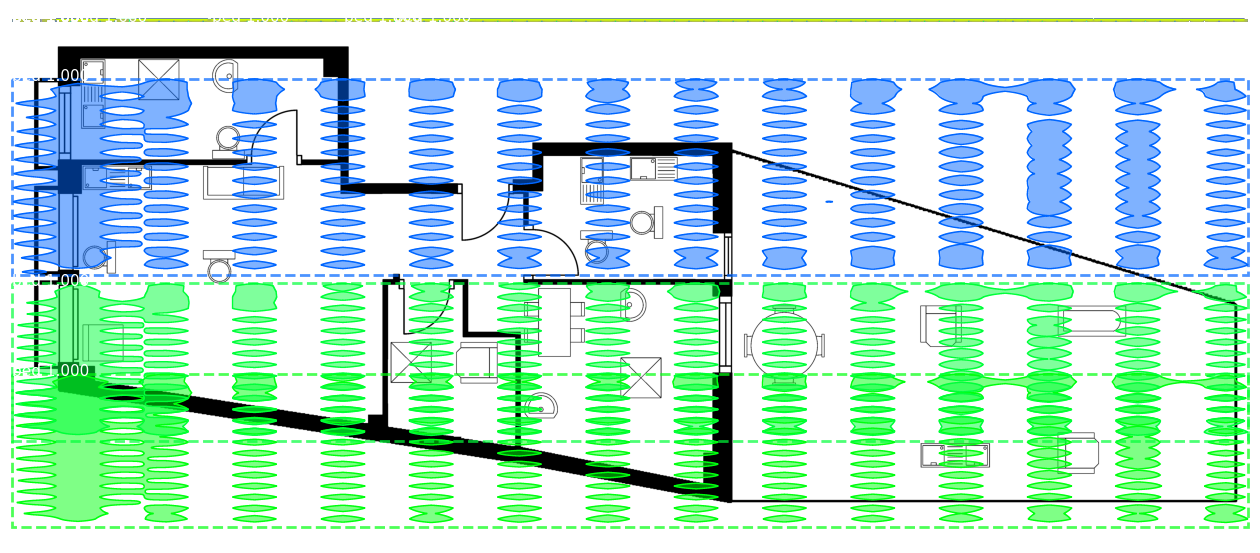

In [15]:
# Visualize the detected objects.
mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])